In [1]:
from functools import partial

import numpy as np

from matplotlib import pyplot as plt

General ops.

In [2]:
def matvec(A, b):
    if b.ndim == 1:
        return np.matmul(A, b)
    return np.einsum("...ij,...j->...i", A, b)

Function equations.

In [3]:
def f(x, lambda_):
    lambda_1, lambda_2 = lambda_
    return lambda_1 * x[..., 0] ** 2 + lambda_2 * x[..., 1] ** 2


def grad_f(x, lambda_):
    return 2 * lambda_ * x[..., :]


def hessian_f(x, lambda_):
    return 2 * np.array([[lambda_[0], 0.0], [0.0, lambda_[1]]])

Dynamical system ops.

In [4]:
def flow(x0, step, n_iter):
    hist = [x0]
    for _ in range(n_iter):
        x1 = grad_step_(x0)
        hist.append(x1)
        x0 = x1

    return np.stack(hist, axis=-2)

In [5]:
lambda_ = np.array([1.0, 10.0])
bounds = ((0.0, 2.0), (0.0, 2.0))

f_lambda = partial(f, lambda_=lambda_)
grad_f_lambda = partial(grad_f, lambda_=lambda_)

In [6]:
num = 10
xs = [
    np.linspace(lower_bound, higher_bound, num=num)
    for lower_bound, higher_bound in bounds
]

x_grid = np.stack(np.meshgrid(*xs), axis=-1)


x_grid.shape

(10, 10, 2)

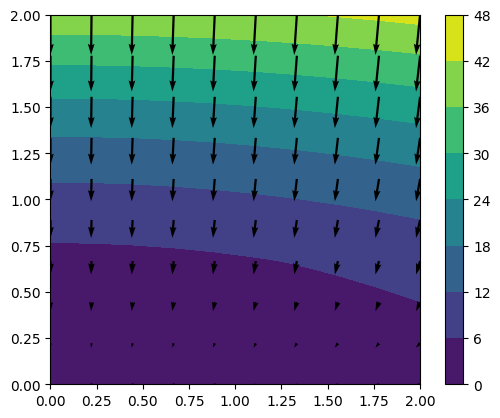

In [7]:
vals = f_lambda(x_grid)
neg_grad = -grad_f_lambda(x_grid)


fig, ax = plt.subplots()
c = ax.contourf(x_grid[..., 0], x_grid[..., 1], vals)
ax.quiver(x_grid[..., 0], x_grid[..., 1], neg_grad[..., 0], neg_grad[..., 1])


ax.set_aspect("equal")
fig.colorbar(c, ax=ax)

## Gradient descent

In [8]:
# TODO: ratios of lambdas?

In [9]:
def grad_step(x, grad_func, alpha=0.1):
    return x - alpha * grad_func(x)


def grad_step_anal(x, lambda_, alpha=0.1):
    mat = np.eye(2) - 2 * alpha * np.array([[lambda_[0], 0.0], [0.0, lambda_[1]]])
    return matvec(mat, x)


def flow_at_k(x0, k, lambda_, alpha=0.1):
    mat = np.array(
        [
            [(1 - 2 * alpha * lambda_[0]) ** k, 0.0],
            [0.0, (1 - 2 * alpha * lambda_[1]) ** k],
        ]
    )
    return matvec(mat, x0)


def eigenvalue(lambda_, alpha):
    return 1 - 2 * alpha * lambda_

In [10]:
x0 = np.array([np.array([0.0, 2.0]), np.array([1.0, 2.0]), np.array([2.0, 2.0])])
n_iter = 10
alpha = 0.01

In [11]:
grad_step_ = partial(grad_step, grad_func=grad_f_lambda, alpha=alpha)

hist = flow(x0, grad_step_, n_iter)

hist.shape

(3, 11, 2)

In [12]:
grad_step_anal_ = partial(grad_step_anal, lambda_=lambda_, alpha=alpha)

np.amax(np.abs(flow(x0, grad_step_anal, n_iter) - hist))

np.float64(0.0)

In [13]:
flow_at_k_ = partial(flow_at_k, lambda_=lambda_, alpha=alpha)


np.amax(np.abs(flow_at_k_(x0, k=5) - hist[:, 5, :]))

np.float64(2.220446049250313e-16)

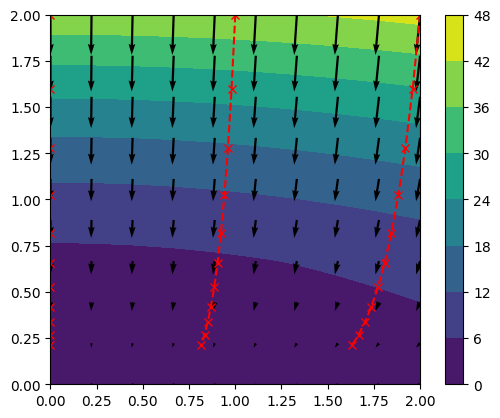

In [14]:
vals = f_lambda(x_grid)
neg_grad = -grad_f_lambda(x_grid)

fig, ax = plt.subplots()

c = ax.contourf(x_grid[..., 0], x_grid[..., 1], vals)
ax.quiver(x_grid[..., 0], x_grid[..., 1], neg_grad[..., 0], neg_grad[..., 1])
for hist_ in hist:
    ax.plot(hist_[..., 0], hist_[..., 1], linestyle="--", marker="x", color="red")

ax.set_aspect("equal")
fig.colorbar(c, ax=ax)

Isostables.

In [15]:
colors = ["green", "red", "blue"]
x0 = np.stack(
    [[(x, y) for y in (0.5, 0.8, 1.5, 2.0)] for x in (0.0, 1.0, 2.0)],
)

n_iter = 100
alpha = 0.01

x0.shape

(3, 4, 2)

In [16]:
grad_step_ = partial(grad_step, grad_func=grad_f_lambda, alpha=alpha)

hist = flow(x0, grad_step_, n_iter)

hist.shape

(3, 4, 101, 2)

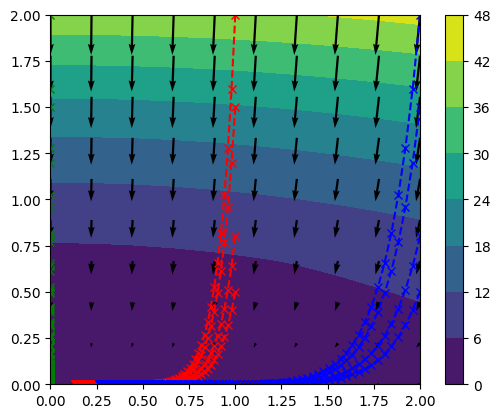

In [17]:
vals = f_lambda(x_grid)
neg_grad = -grad_f_lambda(x_grid)

fig, ax = plt.subplots()

c = ax.contourf(x_grid[..., 0], x_grid[..., 1], vals)
ax.quiver(x_grid[..., 0], x_grid[..., 1], neg_grad[..., 0], neg_grad[..., 1])
for hist_iso, color in zip(hist, colors):
    for hist_ in hist_iso:
        ax.plot(hist_[..., 0], hist_[..., 1], linestyle="--", marker="x", color=color)

ax.set_aspect("equal")
fig.colorbar(c, ax=ax)

Text(0, 0.5, '$||x_k||$')

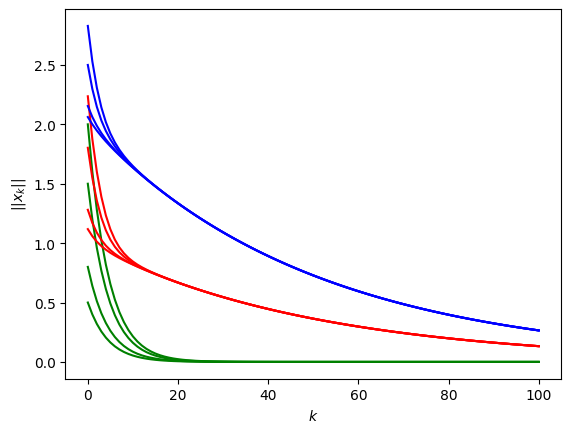

In [18]:
hist_norms = np.linalg.norm(hist, axis=-1)

fig, ax = plt.subplots()
for hist_iso_norms, color in zip(hist_norms, colors):
    for hist_norms in hist_iso_norms:
        ax.plot(np.arange(0, n_iter + 1), hist_norms, color=color)

ax.set_xlabel("$k$")
ax.set_ylabel("$||x_k||$")

In [19]:
# TODO: get alphas in terms of "ratios" of stability

In [20]:
alpha

0.01

Fixing vector fields by exploiting Abby's ideas.

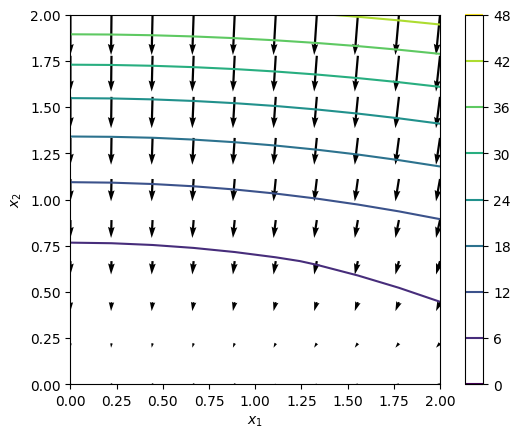

In [21]:
vals = f_lambda(x_grid)
grad_ = -alpha * grad_f_lambda(x_grid)


fig, ax = plt.subplots()

c = ax.contour(x_grid[..., 0], x_grid[..., 1], vals)
ax.quiver(x_grid[..., 0], x_grid[..., 1], grad_[..., 0], grad_[..., 1])

ax.set_aspect("equal")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
fig.colorbar(c, ax=ax)

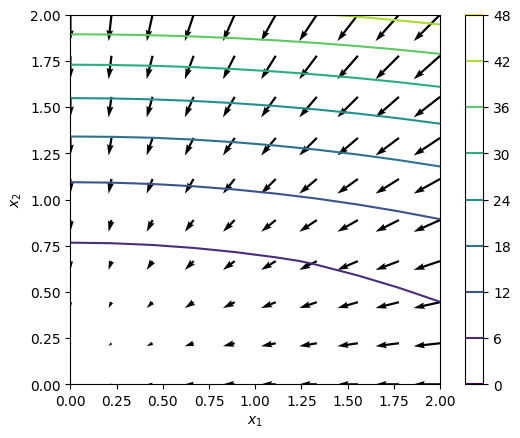

In [22]:
vals = f_lambda(x_grid)

hess = np.array([[1 / (2 * lambda_[0]), 0.0], [0.0, 1 / (2 * lambda_[1])]])
grad_ = -alpha * matvec(hess, (grad_f_lambda(x_grid)))


fig, ax = plt.subplots()

c = ax.contour(x_grid[..., 0], x_grid[..., 1], vals)
ax.quiver(x_grid[..., 0], x_grid[..., 1], grad_[..., 0], grad_[..., 1])

ax.set_aspect("equal")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
fig.colorbar(c, ax=ax)

Unstable example

In [23]:
# explodes if > 0.1
alpha = 0.1

# stability: -1 < alpha*\lambda_i < 0
alpha * lambda_

array([0.1, 1. ])

In [24]:
grad_step_ = partial(grad_step, grad_func=grad_f_lambda, alpha=alpha)

hist = flow(x0, grad_step_, n_iter)

hist.shape

(3, 4, 101, 2)

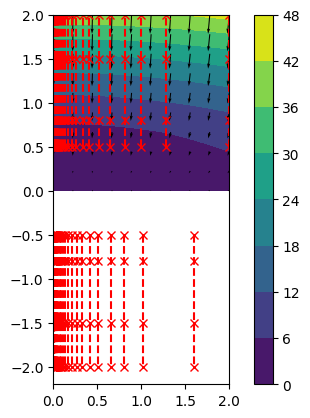

In [25]:
vals = f_lambda(x_grid)

fig, ax = plt.subplots()

c = ax.contourf(x_grid[..., 0], x_grid[..., 1], vals)
ax.quiver(x_grid[..., 0], x_grid[..., 1], neg_grad[..., 0], neg_grad[..., 1])
for hist_ in hist:
    ax.plot(hist_[..., 0], hist_[..., 1], linestyle="--", marker="x", color="red")

ax.set_aspect("equal")
fig.colorbar(c, ax=ax)

## Heavy-ball